In [1]:
!date

Fri Jul  4 02:51:35 PM EDT 2025


In [2]:
pwd

'/projects/sccn/andromeda1/aglinska/BC-ABCD-denoise/Code'

### Get Files

In [3]:
import os
import numpy as np
import pandas as pd
import ants

In [4]:
import importlib

import DeepCor_utils
importlib.reload(DeepCor_utils)

import DeepCor_models
importlib.reload(DeepCor_models)

from DeepCor_utils import *
from DeepCor_models import *

numpy version: 1.20.1
sklearn version: 1.3.2
torch version: 2.4.1+cu121
AntsPy version: 0.5.4
numpy version: 1.20.1
sklearn version: 1.3.2
torch version: 2.4.1+cu121
AntsPy version: 0.5.4


In [5]:
# Parameters for looping. 
s = 30 # index for subject (out of 14)
r = 1 # index for run (out of 4)
analysis_name = 'ABCD-refactored-test' # This is be appended to the saved output files 

In [6]:
indir = '../Data/020-fmriprepped'
subs = [s for s in os.listdir(indir) if all((s.startswith('sub'),not s.endswith('.html')))]
subs.sort()
print(f'{s}/{len(subs)}')
n_orig = len(subs)
sub = subs[s]
sub

4/34


'sub-NDARINV6WXU5DEY'

In [7]:
# epi_fn = os.path.join(indir,'{sub}/ses-localizer/func/{sub}_ses-localizer_task-objectcategories_run-{r}_bold_space-MNI152NLin2009cAsym_preproc.nii.gz')
# cf_fn = os.path.join(indir,'mask_roni.nii')
# gm_fn = os.path.join(indir,'mask_roi.nii')
# conf_fn = os.path.join(indir,f'{sub}/ses-localizer/func/{sub}_ses-localizer_task-objectcategories_run-{r}_bold_confounds.tsv')

In [8]:
epi_fn = os.path.join(indir,sub,'ses-baselineYear1Arm1','func',f'{sub}_ses-baselineYear1Arm1_task-nback_run-0{r}_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz')
anat_fn = os.path.join(indir,sub,'ses-baselineYear1Arm1','anat',f'{sub}_ses-baselineYear1Arm1_run-01_space-MNI152NLin2009cAsym_res-2_desc-preproc_T1w.nii.gz')
anat_gm_fn = os.path.join(indir,sub,'ses-baselineYear1Arm1','anat',f'{sub}_ses-baselineYear1Arm1_run-01_space-MNI152NLin2009cAsym_res-2_label-GM_probseg.nii.gz')
anat_wm_fn = os.path.join(indir,sub,'ses-baselineYear1Arm1','anat',f'{sub}_ses-baselineYear1Arm1_run-01_space-MNI152NLin2009cAsym_res-2_label-WM_probseg.nii.gz')
anat_csf_fn = os.path.join(indir,sub,'ses-baselineYear1Arm1','anat',f'{sub}_ses-baselineYear1Arm1_run-01_space-MNI152NLin2009cAsym_res-2_label-CSF_probseg.nii.gz')
conf_fn = os.path.join(indir,sub,'ses-baselineYear1Arm1','func',f'{sub}_ses-baselineYear1Arm1_task-nback_run-0{r}_desc-confounds_timeseries.tsv')
events_fn = os.path.join(f'../Data/011-ABCD-events/{sub}_ses-baselineYear1Arm1_task-nback_run-0{r}_events.tsv')

In [9]:
epi = ants.image_read(epi_fn.format(sub=sub,r=r))
anat = ants.image_read(anat_fn.format(sub=sub,r=r))
anat_gm = ants.image_read(anat_gm_fn.format(sub=sub,r=r))
anat_wm = ants.image_read(anat_wm_fn.format(sub=sub,r=r))
anat_csf = ants.image_read(anat_csf_fn.format(sub=sub,r=r))
df_conf = pd.read_csv(conf_fn,delimiter='\t')

In [10]:
## EPI parameters: Check that these are correct
nTR = epi.shape[-1]
t_r = round(epi.spacing[-1],2)
ndummy = 8

print(f'Number of scans: {nTR}')
print(f'Repetition Time: {t_r}')
print(f'Dummy scans to discard: {ndummy}')

Number of scans: 370
Repetition Time: 0.8
Dummy scans to discard: 8


In [11]:
# Directory where to save the outputs
ofdir_root = '../Data/StudyForrest/ensembles_last_CVAE'
ofdir = os.path.join(ofdir_root,analysis_name)
safe_mkdir(ofdir)
print(ofdir)

../Data/StudyForrest/ensembles_last_CVAE/ABCD-refactored-test


## Post-training analyses

In [12]:
events_fn = os.path.join(events_fn)
X1 = get_design_matrix(epi,events_fn)
X1

,0_back_negface,0_back_neutface,0_back_place,0_back_posface,2_back_negface,2_back_neutface,2_back_place,2_back_posface,cue,dummy,drift_1,drift_2,drift_3,constant
0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,-0.50000,0.166215,-0.049594,1.0
0.8,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000189,-0.49729,0.163512,-0.047981,1.0
1.6,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.006770,-0.49458,0.160824,-0.046391,1.0
2.4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.041190,-0.49187,0.158151,-0.044821,1.0
3.2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.123477,-0.48916,0.155492,-0.043274,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292.0,0.0,0.0,-0.065119,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.48916,0.155492,0.043274,1.0
292.8,0.0,0.0,-0.054122,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.49187,0.158151,0.044821,1.0
293.6,0.0,0.0,-0.044002,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.49458,0.160824,0.046391,1.0
294.4,0.0,0.0,-0.035054,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.49729,0.163512,0.047981,1.0


In [13]:
# If no post-training analyses needed, leave these empty
correlation_analyses = []
contrast_analyses = []

In [14]:
correlation_analyses.append(
    {'corr_target' : X1[['0_back_negface','0_back_neutface','0_back_posface','2_back_neutface','2_back_posface']].values.mean(axis=1),
     'filename' : os.path.join(ofdir,f'corr2face_S{s}_R{r}.nii.gz'),
     'plot' : True, 
     'ROI' : '../Misc/ffa_mask_resampled.nii'
    })

correlation_analyses.append(
    {'corr_target' : X1[['0_back_place','2_back_place']].values.sum(axis=-1),
     'filename' : os.path.join(ofdir,f'corr2place_S{s}_R{r}.nii.gz'),
     'plot' : True,
     'ROI' : '../Misc/ppa_mask_resampled_97_115_97.nii.gz'
    })

contrast_analyses.append(
    {'contrast_vec' : [1,1,-3,1,1,1,-3,1,0,0,0,0,0,0],
     'design_matrix' : X1,
     'filename' : os.path.join(ofdir,f'contrast_face_{s}_R{r}.nii.gz'),
     'plot' : True, 
     'ROI' : '../Misc/ffa_mask_resampled.nii'
    })

contrast_analyses.append(
    {'contrast_vec' : [-1,-1,3,-1,-1,-1,3,-1,0,0,0,0,0,0],
     'design_matrix' : X1,
     'filename' : os.path.join(ofdir,f'contrast_place_S{s}_R{r}.nii.gz'),
     'plot' : True,
     'ROI' : '../Misc/ppa_mask_resampled_97_115_97.nii.gz'
    })

In [15]:
# Model Hyperparameters
hyperparams_cvae = {}
hyperparams_cvae['nrep'] = 10
hyperparams_cvae['epoch_num'] = 100
hyperparams_cvae['batch_size'] = 1024
hyperparams_cvae['latent_dim'] = (8,8) # Shared,Specific
#hyperparams_cvae['beta'] = 0.01
hyperparams_cvae['beta'] = 1e-5
hyperparams_cvae['gamma'] = 0 # TC scaling
hyperparams_cvae['delta'] = 0 # "Denoised RONI should be zero" scaling
hyperparams_cvae['scale_MSE_GM'] = 1e3 # Scale ROI loss 
hyperparams_cvae['scale_MSE_CF'] = 1e3 # Scale RONI loss
hyperparams_cvae['scale_MSE_FG'] = 0 # "Denoised should be similar to input" scaling
# Optimizer
hyperparams_cvae['lr']=0.001
hyperparams_cvae['betas']=(0.9, 0.999)
hyperparams_cvae['eps']=1e-08

# END of user-specified parameters

In [16]:
epi,df_conf = apply_dummy(epi,df_conf,ndummy)

In [17]:
epi,df_conf = apply_frame_censoring(epi,df_conf,df_conf['framewise_displacement'].values>.9,also_nearby_voxels=True)

Censored 43.24% of voxels 160/370


/projects/sccn/andromeda1/aglinska/BC-ABCD-denoise/Code/DeepCor_utils.py:592: UserWarning: High number of censored frames: consider lowering the treshold or removing the subject from analyses
  warnings.warn('High number of censored frames: consider lowering the treshold or removing the subject from analyses')


In [18]:
def regress_out_confounds(epi,mask,conf_arr,do_center=True):
    from sklearn.decomposition import PCA
    from sklearn import linear_model

    nTR = epi.shape[-1]
    epi_flat = epi.numpy().reshape(-1,nTR)
    mask_idx = mask.numpy().flatten()==1
    epi_flat_masked = epi_flat[mask_idx,:]

    epi_flat_T = epi_flat_masked.transpose()
    X = conf_arr.copy()

    if do_center==True:
        std0 = epi_flat.std(axis=-1)<1e-3
        epi_flat[~std0,:] = (epi_flat[~std0,:]-epi_flat[~std0,:].mean(axis=-1)[:,np.newaxis])/epi_flat[~std0,:].std(axis=-1)[:,np.newaxis] # Z-score the data
        epi_flat[std0,:]=0

        X[np.isnan(X)]=0
        X = (X-X.mean(axis=0))/X.std(axis=0)

    lin_reg = linear_model.LinearRegression()
    lin_reg.fit(X, epi_flat_T)
    predicted = lin_reg.predict(X)
    residuals = (epi_flat_T - predicted).T
    res = np.zeros(epi_flat.shape)
    res[mask_idx] = residuals
    epi_cleaned = epi.new_image_like(res.reshape(epi.shape))
    
    return epi_cleaned

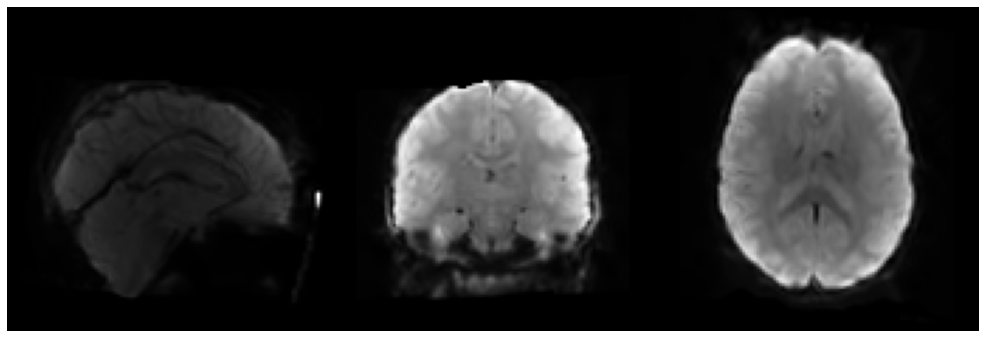

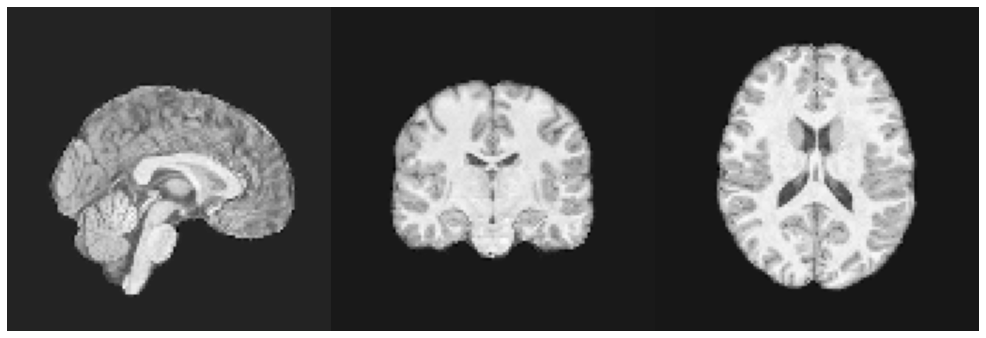

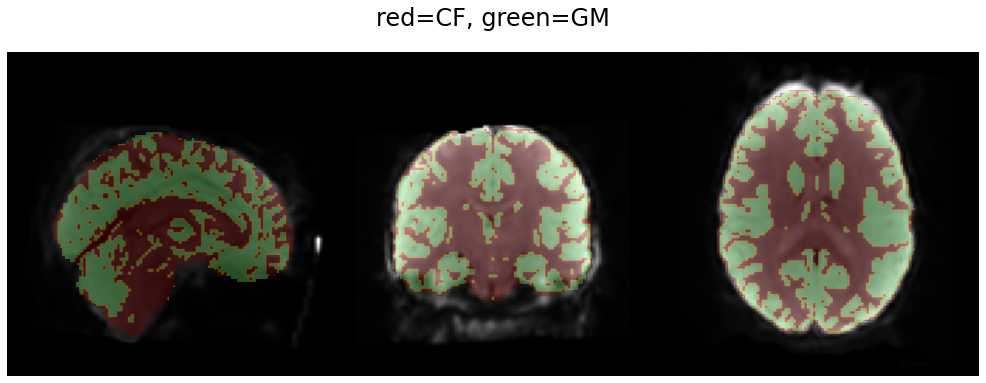

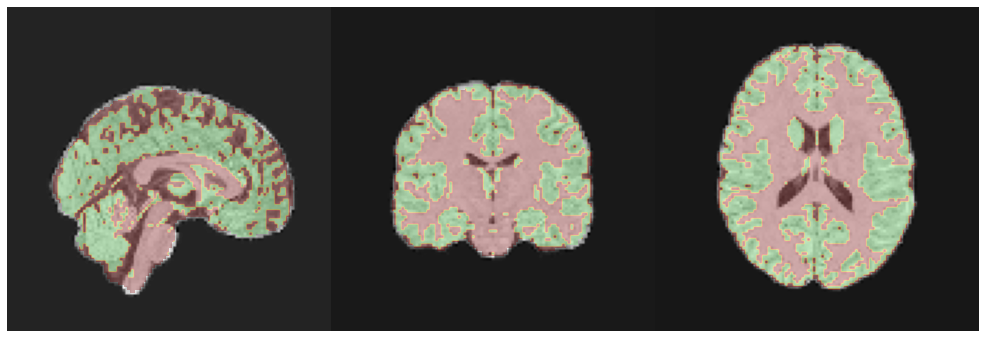

In [19]:
gm,cf = get_roi_and_roni(epi,anat,anat_gm,anat_wm,anat_csf,do_plot=True) # If using individual masks

/home/aglinska/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


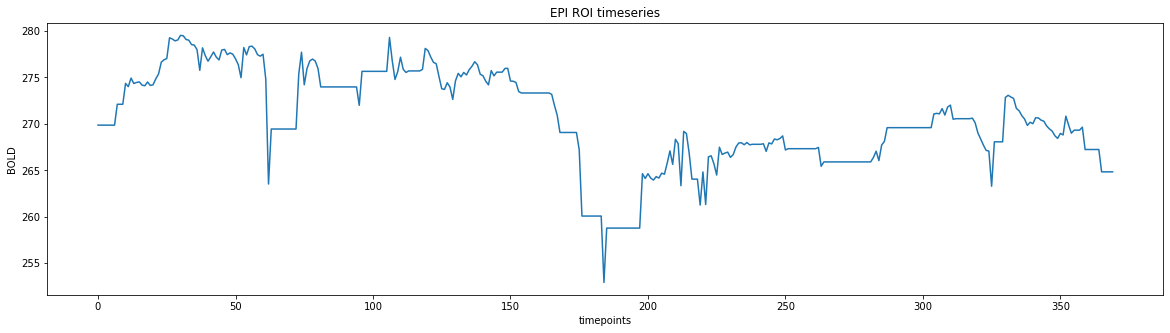

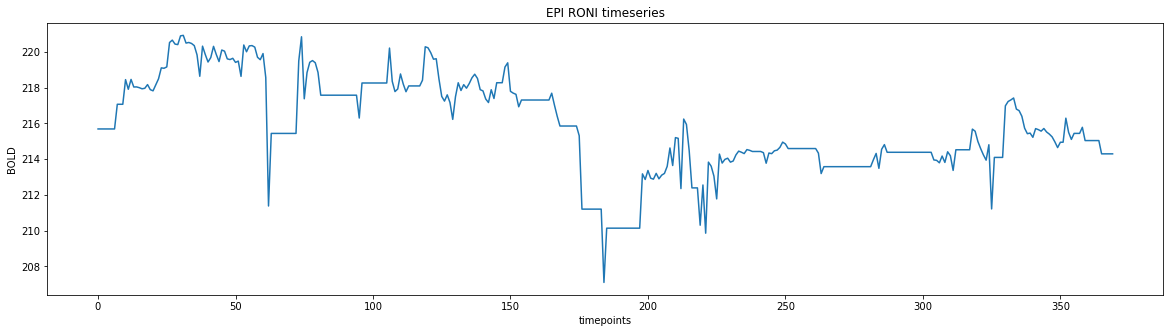

In [20]:
plot_timeseries(epi,gm,cf)

In [21]:
#epi = regress_out_confounds(epi,(gm+cf),df_conf[['trans_x','trans_y','trans_z','rot_x','rot_y','rot_z']].values)
#epi = regress_out_confounds(epi,(gm+cf),df_conf[['a_comp_cor_00','a_comp_cor_01','a_comp_cor_02','a_comp_cor_03','a_comp_cor_04']].values)
#epi = regress_out_confounds(epi,(gm+cf),df_conf[['trans_x','trans_y','trans_z','rot_x','rot_y','rot_z','a_comp_cor_00','a_comp_cor_01','a_comp_cor_02','a_comp_cor_03','a_comp_cor_04']].values)

/home/aglinska/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
use_cols = ['trans_x','trans_y','trans_z', 'rot_x','rot_y','rot_z']
#use_cols = ['X','Y','Z','RotX','RotY','RotZ']
assert np.isnan(df_conf.loc[:,use_cols].values).sum()==0,'NaNs in motion'
conf = df_conf.loc[:,use_cols].values.transpose()
conf[0:3,:] = (conf[0:3,:]-conf[0:3,:].min()) / (conf[0:3,:].max()-conf[0:3,:].min())
conf[3:,:] = (conf[3:,:]-conf[3:,:].min()) / (conf[3:,:].max()-conf[3:,:].min())
print(df_conf.shape)
df_conf.head()

(370, 169)


/home/aglinska/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,global_signal,global_signal_derivative1,global_signal_power2,global_signal_derivative1_power2,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,...,motion_outlier76,motion_outlier77,motion_outlier78,motion_outlier79,motion_outlier80,motion_outlier81,motion_outlier82,motion_outlier83,motion_outlier84,motion_outlier85
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


/home/aglinska/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


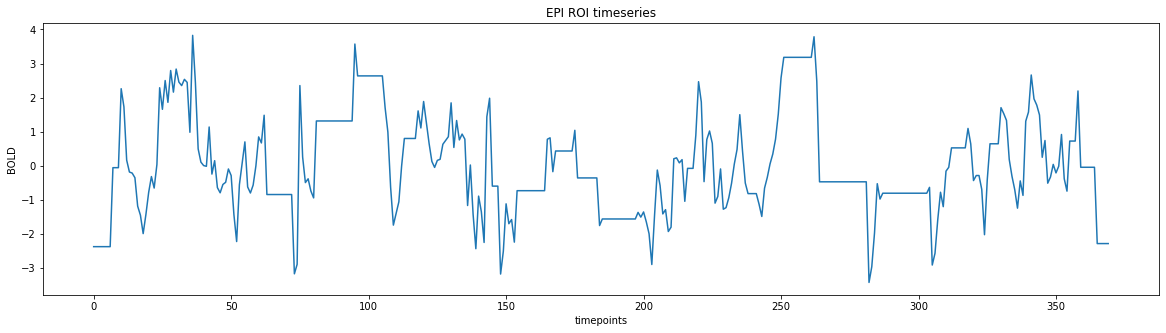

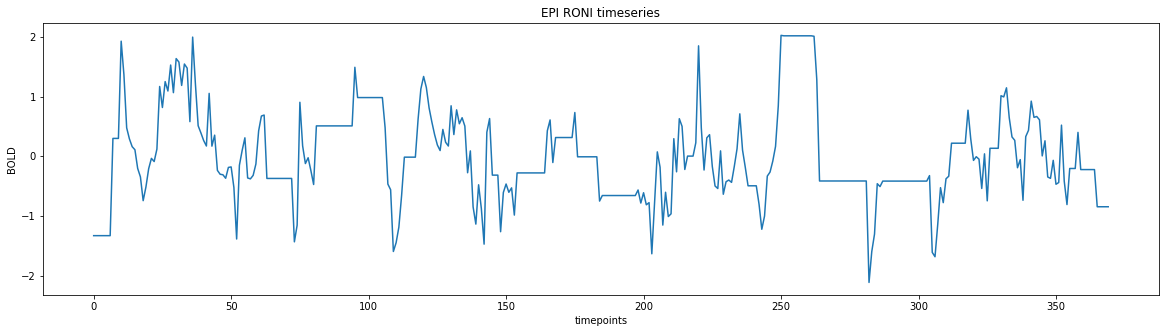

In [23]:
plot_timeseries(epi,gm,cf)

/home/aglinska/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, "['a_comp_cor_01', 'a_comp_cor_02', 'a_comp_cor_03', 'a_comp_cor_04', 'a_comp_cor_05']")

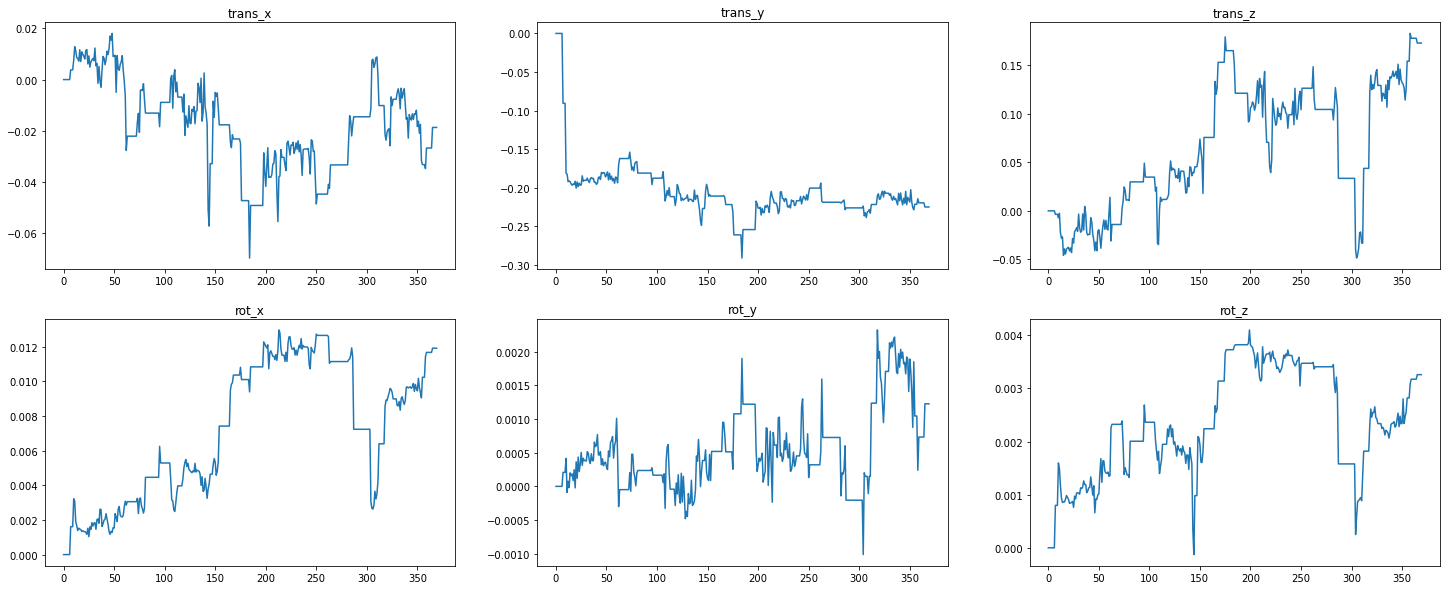

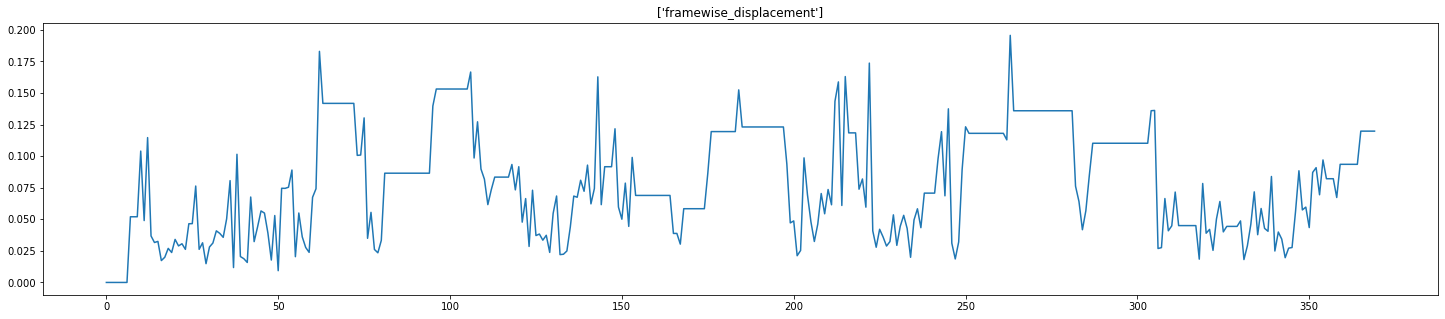

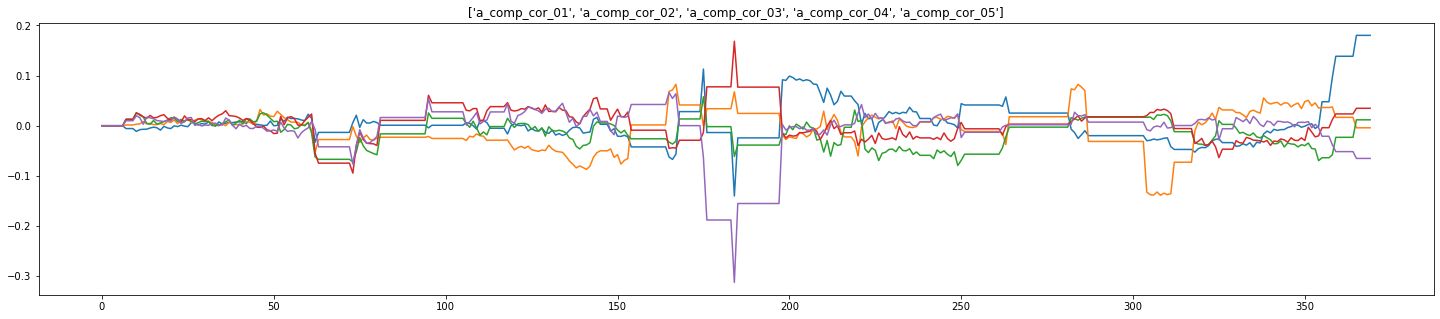

In [24]:
conf_keys_xyz_rot = ['trans_x','trans_y','trans_z','rot_x','rot_y','rot_z']
#conf_keys_xyz_rot = ['X','Y','Z','RotX','RotY','RotZ']
plt.figure(figsize=(25,10))
nrows = 2
ncols = 3
sp=0
for key in conf_keys_xyz_rot:
    sp=sp+1;plt.subplot(nrows,ncols,sp)
    plt.plot(df_conf[key].values)
    plt.title(key)
    
plt.figure(figsize=(25,5))
conf_keys_fd = ['framewise_displacement']
#conf_keys_fd = ['FramewiseDisplacement']
plt.plot(df_conf[conf_keys_fd].values)
thresh=.2
vec = (df_conf[conf_keys_fd].values>thresh)*1.0*df_conf[conf_keys_fd].values
vec[vec==0]=np.nan
plt.plot(vec,'r*',markersize=15)
plt.title(conf_keys_fd)

plt.figure(figsize=(25,5))
conf_keys_pca = ['a_comp_cor_01','a_comp_cor_02',  'a_comp_cor_03',  'a_comp_cor_04','a_comp_cor_05']
#conf_keys_pca = ['aCompCor01','aCompCor02',  'aCompCor03',  'aCompCor04','aCompCor05']
plt.plot(df_conf[conf_keys_pca].values)
plt.title(conf_keys_pca)

In [25]:
obs_list_coords,noi_list_coords,gm,cf = get_obs_noi_list_coords(epi,gm,cf)

/home/aglinska/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


obs_list_coords.shape: (124262, 4, 370)
noi_list_coords.shape: (111949, 4, 370)
upsampling noi_list_coords
obs_list_coords.shape: (124262, 4, 370)
noi_list_coords.shape: (124262, 4, 370)


In [26]:
# Run some sanity check, for flat voxels (not good for training) and NaNs
assert np.isnan(obs_list_coords).sum()==0, 'NaNs in obs_list_coords'
assert np.isnan(noi_list_coords).sum()==0, 'NaNs in noi_list_coords'
assert (obs_list_coords[:,0,:].std(axis=-1)<1e-3).sum()==0,'Std0 in obs_list_coords'
assert (noi_list_coords[:,0,:].std(axis=-1)<1e-3).sum()==0,'Std0 in noi_list_coords'

In [27]:
import importlib

import DeepCor_utils
importlib.reload(DeepCor_utils)

import DeepCor_models

importlib.reload(DeepCor_models)

from DeepCor_utils import *
from DeepCor_models import *

numpy version: 1.20.1
sklearn version: 1.3.2
torch version: 2.4.1+cu121
AntsPy version: 0.5.4


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

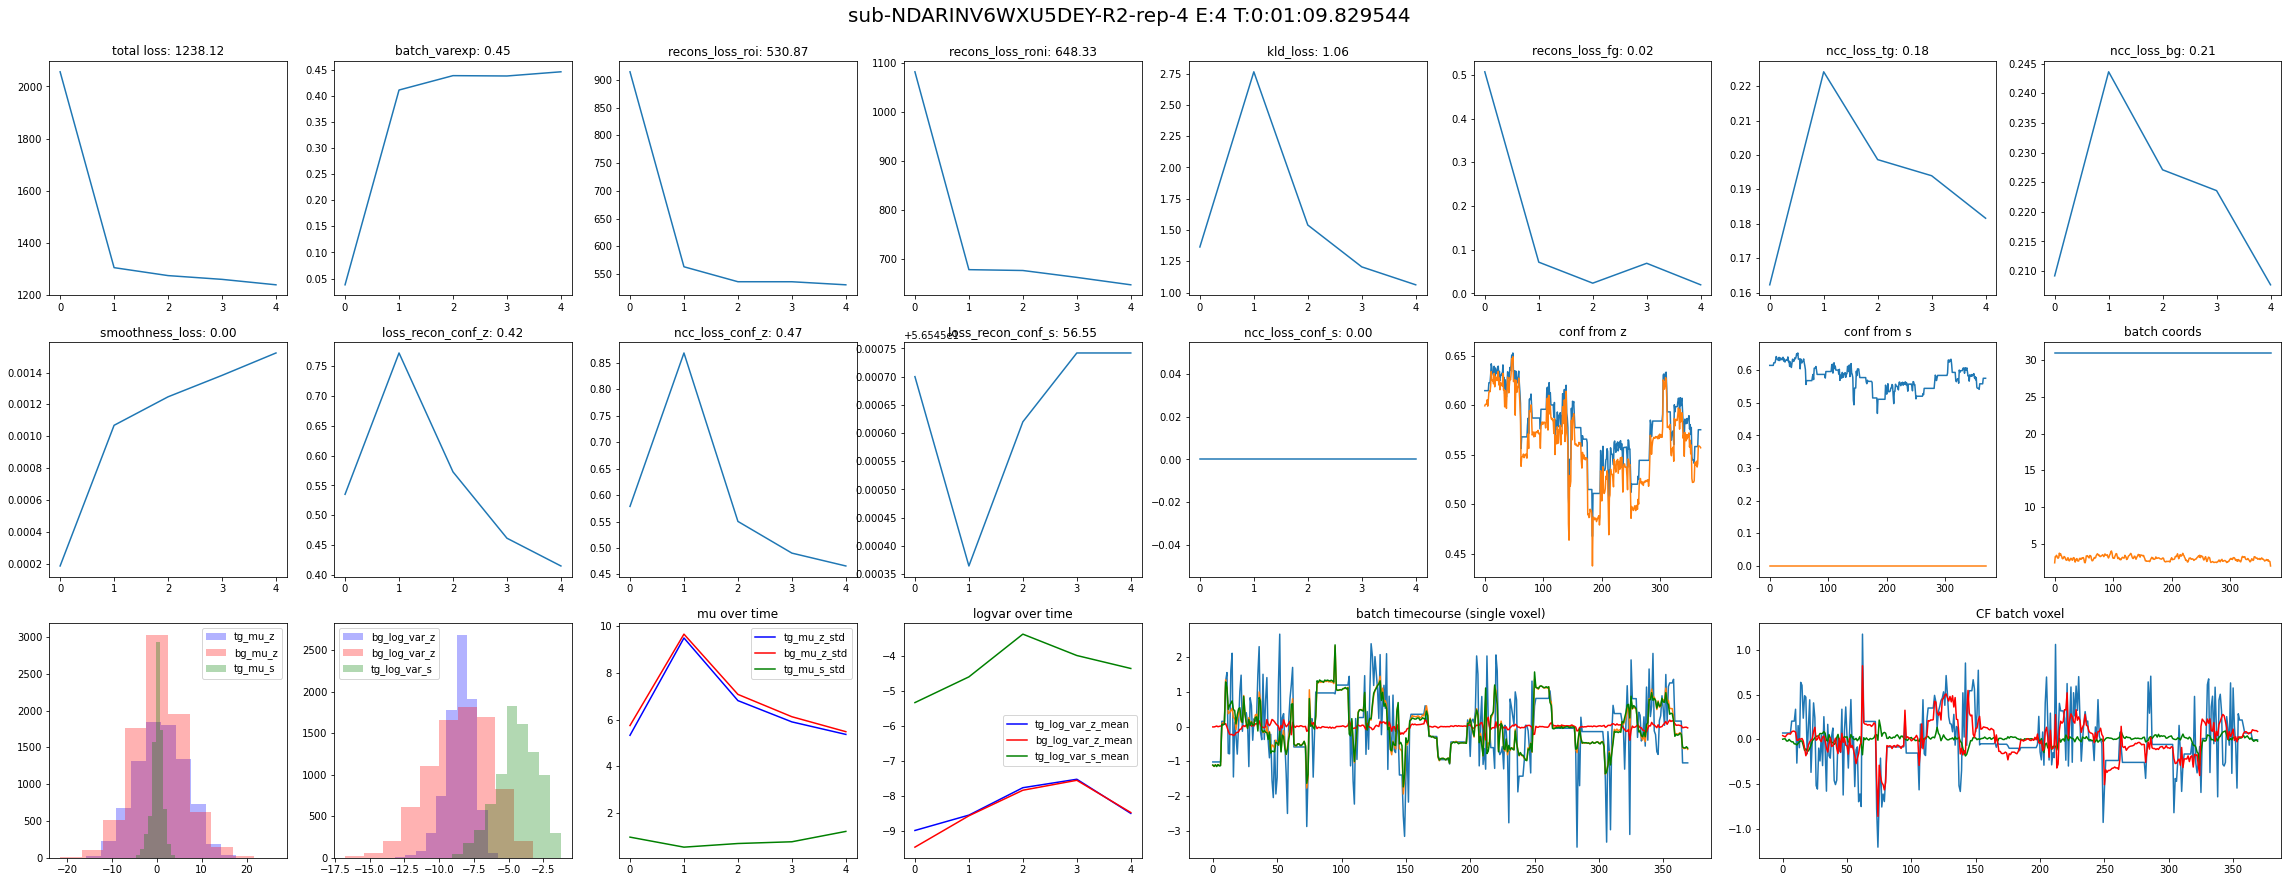

100%|██████████| 5/5 [10:07<00:00, 121.58s/it]

done training
[]


In [28]:
import traceback

nrep = hyperparams_cvae.get('nrep',20)
epoch_num = hyperparams_cvae.get('epoch_num',100)
batch_size = hyperparams_cvae.get('batch_size',512)
latent_dim = hyperparams_cvae.get('latent_dim',(8,8))
beta = hyperparams_cvae.get('beta',0.01)       
gamma = hyperparams_cvae.get('gamma',0)       
delta = hyperparams_cvae.get('delta',0)       
scale_MSE_GM = hyperparams_cvae.get('scale_MSE_GM',1e3)       
scale_MSE_CF = hyperparams_cvae.get('scale_MSE_CF',1e3)      
scale_MSE_FG = hyperparams_cvae.get('scale_MSE_FG',0) # "Denoised should be similar to input" scaling
lr = hyperparams_cvae.get('lr',0.001)

print(f'nrep: {nrep}')
print(f'epoch_num: {epoch_num}')
print(f'batch_size: {batch_size}')
print(f'latent_dim: {latent_dim}')
print(f'beta: {beta}')
print(f'gamma: {gamma}')
print(f'delta: {delta}')
print(f'scale_MSE_GM: {scale_MSE_GM}')
print(f'scale_MSE_CF: {scale_MSE_CF}')
print(f'scale_MSE_FG: {scale_MSE_FG}')
print(f'lr: {lr}')

train_inputs_coords = TrainDataset(obs_list_coords,noi_list_coords)
train_in_coords = torch.utils.data.DataLoader(train_inputs_coords, batch_size=batch_size,shuffle=True, num_workers=1,drop_last=True)

global device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'device is {device}')
Tensor = TypeVar('torch.tensor')
conf_batch = torch.tensor(np.array([conf for _ in range(batch_size)])).to(device)

keys = ['l', 'kld_loss', 'recons_loss_roi', 'recons_loss_roni',
       'loss_recon_conf_s', 'loss_recon_conf_z', 'ncc_loss_tg',
       'ncc_loss_bg', 'ncc_loss_conf_s', 'ncc_loss_conf_z',
       'smoothness_loss', 'recons_loss_fg',  'batch_varexp',
        'tg_mu_z', 'tg_log_var_z', 'tg_mu_s', 'tg_log_var_s',
        'tg_z', 'tg_s', 'bg_log_var_z', 'bg_mu_z',
        'tg_log_var_z_mean','bg_log_var_z_mean','tg_log_var_s_mean',
        'tg_mu_z_std','bg_mu_z_std','tg_mu_s_std','batch_signal',
        'batch_noise','batch_in','batch_out','batch_varexp',
        'confounds_pred_z','confounds_pred_s',]


track = init_track(keys)
errors = []

for rep in tqdm(range(nrep)):
    try:
        track = init_track(keys)
        track['sub'] = sub
        track['s'] = s
        track['r'] = r
        track['ofdir'] = ofdir
        track['conf'] = conf
        track['rep'] = rep
        
        track_ofn = os.path.join(ofdir,f'track_S{s}_R{r}_rep_{rep}.pickle')
        model_ofn = os.path.join(ofdir,f'model_S{s}_R{r}_rep_{rep}.pickle')
        
        model = cVAE(conf_batch,4,nTR,latent_dim, beta=beta, gamma=gamma,delta=delta,scale_MSE_GM=scale_MSE_GM,scale_MSE_CF=scale_MSE_CF,scale_MSE_FG=scale_MSE_FG,freq_exp=0,freq_scale=0,do_disentangle=True)
        model.to(device)
        optimizer = optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08)
        
        for epoch in range(epoch_num):  # loop over the dataset multiple times    
            model.train()
            dataloader_iter_in = iter(train_in_coords)
            track['epoch'] = epoch
            for i in range(len(train_in_coords)):
                optimizer.zero_grad()
                inputs_gm,inputs_cf = next(dataloader_iter_in)

                inputs_gm = inputs_gm.float().to(device)
                inputs_cf = inputs_cf.float().to(device)

                [outputs_gm, inputs_gm, tg_mu_z, tg_log_var_z, tg_mu_s, tg_log_var_s,tg_z,tg_s] = model.forward_tg(inputs_gm)
                [outputs_cf, inputs_cf, bg_mu_z, bg_log_var_z] = model.forward_bg(inputs_cf)

                loss = model.loss_function(outputs_gm, inputs_gm, tg_mu_z, tg_log_var_z, tg_mu_s, tg_log_var_s,tg_z,tg_s, outputs_cf, inputs_cf, bg_mu_z, bg_log_var_z)

                if np.isnan(loss['loss'].detach().cpu().numpy()): raise ValueError(f'{rep}|{epoch}|{i}: loss is NaN') # If loss is NaNs, abort training and move on to the next repetition
                    
                loss['loss'].backward() # Do a backward pass
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)  # Prevent gradient explosion
                optimizer.step()
                
            track = update_track(track,model,inputs_gm,inputs_cf)
        
            show_bashboard(track,single_fig=True)
            
        save_model(model_ofn,model,optimizer,epoch,loss)
        save_track(track_ofn,track)
        save_brain_signals(model,train_inputs_coords,epi,gm,ofn=os.path.join(ofdir,f'signal_S{s}_R{r}_rep_{rep}.nii.gz'),batch_size=512,kind='FG')
        save_brain_signals(model,train_inputs_coords,epi,gm,ofn=os.path.join(ofdir,f'recon_S{s}_R{r}_rep_{rep}.nii.gz'),batch_size=512,kind='TG') # Optional to save reconstructions
        save_brain_signals(model,train_inputs_coords,epi,gm,ofn=os.path.join(ofdir,f'noise_S{s}_R{r}_rep_{rep}.nii.gz'),batch_size=512,kind='BG') # Optional to save noise estimates       
                            
    except:
        errors.append(f'{rep}|{epoch}|{i}: loss is NaN')
        traceback.print_exc()
print('done training')
print(errors)

In [29]:
signal_files = [os.path.join(ofdir,f) for f in os.listdir(ofdir) if all((f.startswith(f'signal_S{s}_R{r}_rep_'),f.endswith('.nii.gz')))]
track_files = [os.path.join(ofdir,f) for f in os.listdir(ofdir) if all((f.startswith(f'track_S{s}_R{r}_rep_'),f.endswith('.pickle')))] 
signal_files.sort()
track_files.sort()
print('Ensemble of {} repetitions'.format(len(signal_files)))

Ensemble of 5 repetitions


/home/aglinska/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
signals_averaged = average_signal_ensemble(signal_files,os.path.join(ofdir,f'signal_S{s}_R{r}_avg.nii.gz'))

100%|██████████| 5/5 [00:37<00:00,  7.48s/it]


signals averaged: 5


In [31]:
array_to_brain(obs_list_coords[:,0,:],epi,gm,os.path.join(ofdir,f'preproc_S{s}_R{r}.nii.gz'),inv_z_score=True,return_img=False)

In [32]:
compcor = calc_and_save_compcor(epi,gm,cf,os.path.join(ofdir,f'compcor_S{s}_R{r}.nii.gz'),n_components=5,return_img=True)

/home/aglinska/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


saved as: ../Data/StudyForrest/ensembles_last_CVAE/ABCD-refactored-test/corr2face_S4_R2_preproc.nii.gz
saved as: ../Data/StudyForrest/ensembles_last_CVAE/ABCD-refactored-test/corr2face_S4_R2_compcor.nii.gz
saved as: ../Data/StudyForrest/ensembles_last_CVAE/ABCD-refactored-test/corr2face_S4_R2_deepcor.nii.gz
saved as: ../Data/StudyForrest/ensembles_last_CVAE/ABCD-refactored-test/corr2place_S4_R2_preproc.nii.gz
saved as: ../Data/StudyForrest/ensembles_last_CVAE/ABCD-refactored-test/corr2place_S4_R2_compcor.nii.gz
saved as: ../Data/StudyForrest/ensembles_last_CVAE/ABCD-refactored-test/corr2place_S4_R2_deepcor.nii.gz


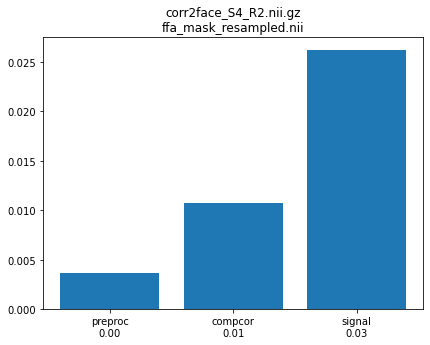

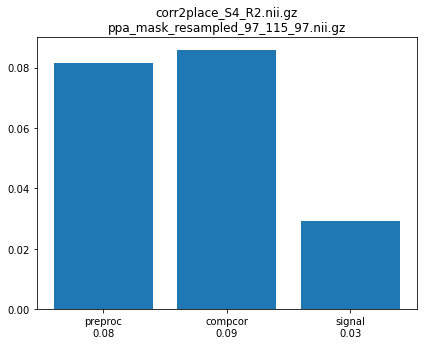

In [33]:
for analysis_spec in correlation_analyses:
    run_correlation_analysis_from_spec(analysis_spec,epi,compcor,signals_averaged,gm)

saved as: ../Data/StudyForrest/ensembles_last_CVAE/ABCD-refactored-test/contrast_face_4_R2_preproc.nii.gz
saved as: ../Data/StudyForrest/ensembles_last_CVAE/ABCD-refactored-test/contrast_face_4_R2_compcor.nii.gz
saved as: ../Data/StudyForrest/ensembles_last_CVAE/ABCD-refactored-test/contrast_face_4_R2_deepcor.nii.gz
saved as: ../Data/StudyForrest/ensembles_last_CVAE/ABCD-refactored-test/contrast_place_S4_R2_preproc.nii.gz
saved as: ../Data/StudyForrest/ensembles_last_CVAE/ABCD-refactored-test/contrast_place_S4_R2_compcor.nii.gz
saved as: ../Data/StudyForrest/ensembles_last_CVAE/ABCD-refactored-test/contrast_place_S4_R2_deepcor.nii.gz


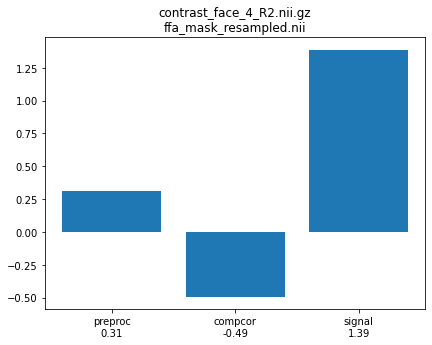

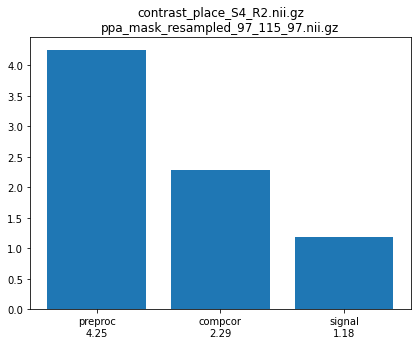

In [34]:
for analysis_spec in contrast_analyses:
    run_contrast_analysis_from_spec(analysis_spec,epi,compcor,signals_averaged,gm)

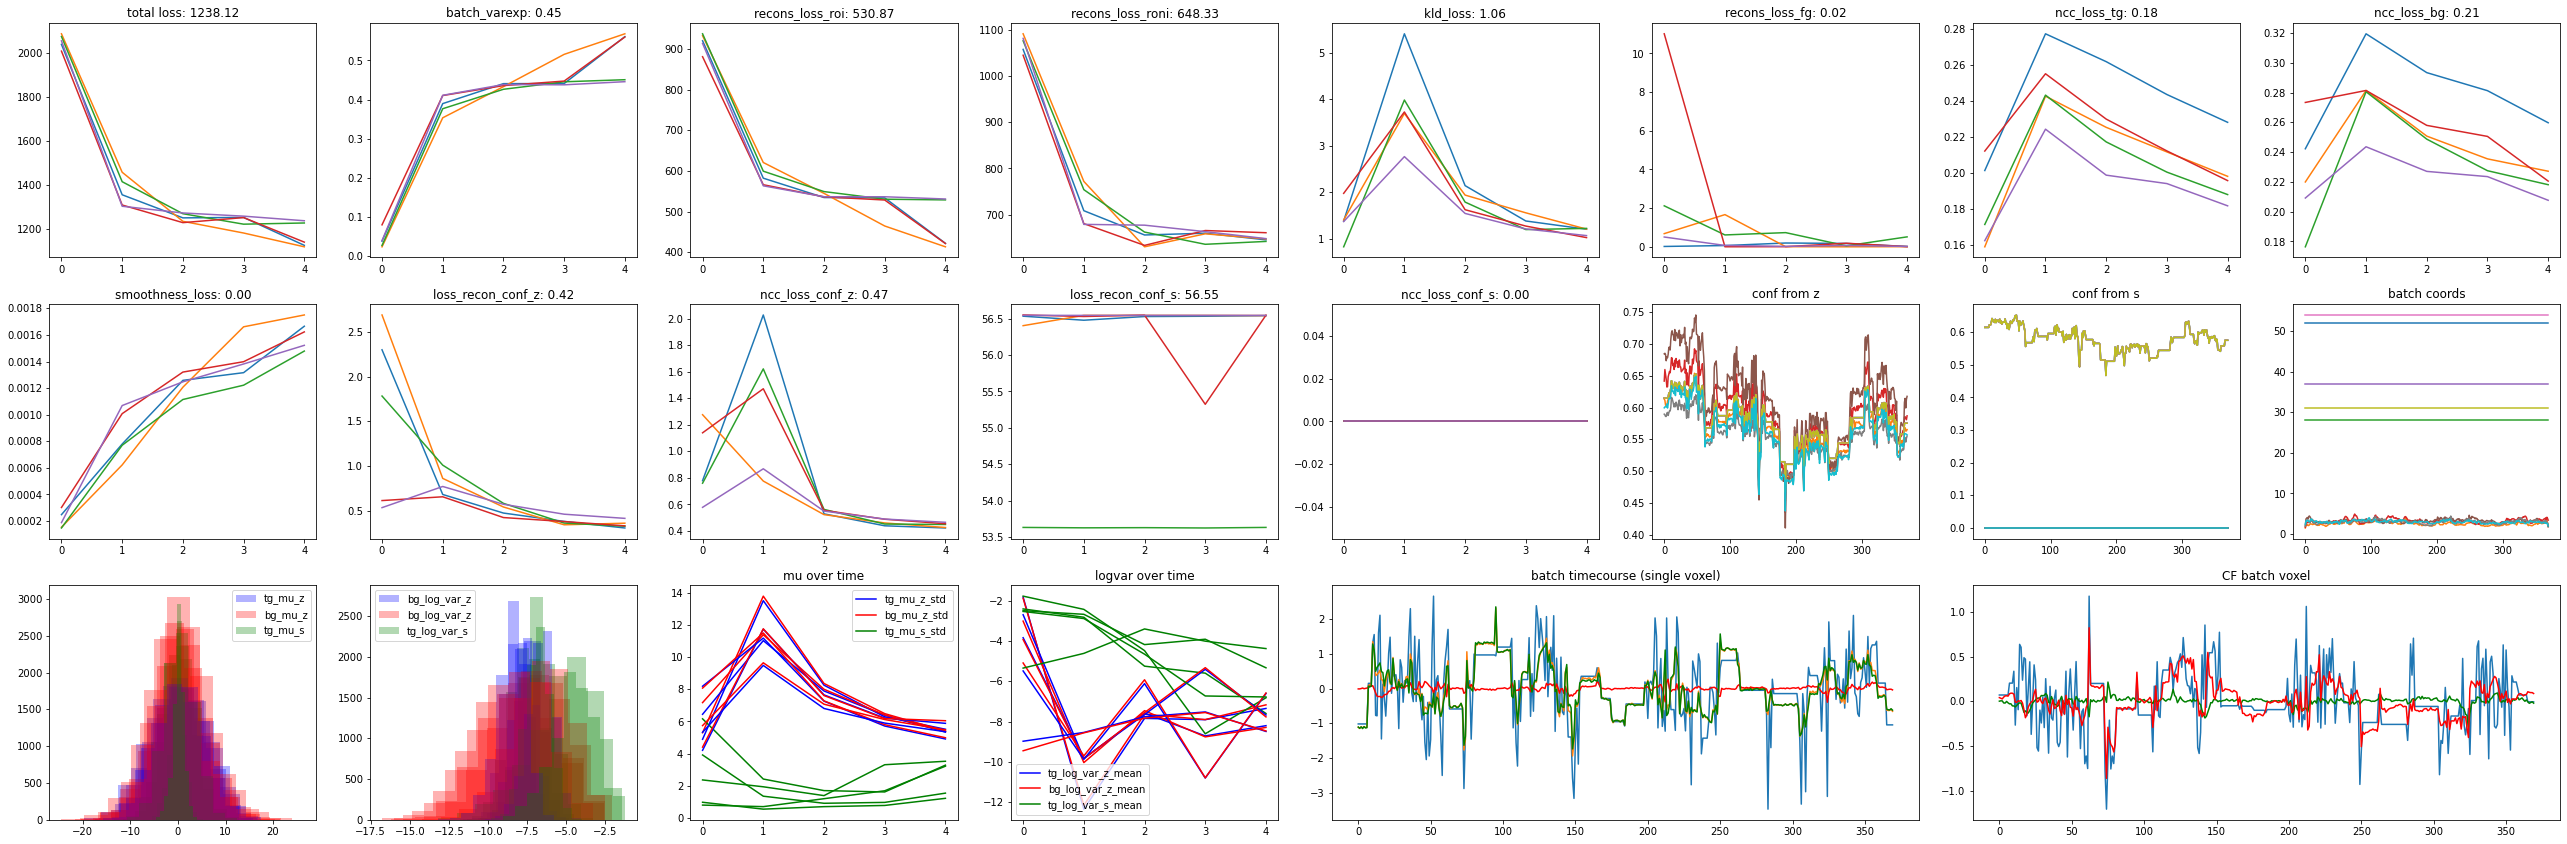

In [35]:
tracks = [load_pickle(track_file) for track_file in track_files]
import warnings
warnings.filterwarnings("ignore")
plt.figure(figsize=(5*9,5*5))
for track in tracks:
    try:
        show_bashboard(track,single_fig=False)
    except:
        print('bad track')

In [1]:
!date

Sat Jul  5 10:07:41 PM EDT 2025
